## Downloading packages

In [1]:
!pip install trimesh
#!pip install open3d
!pip install --upgrade ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: jupyterlab_widgets
    Found existing installation: jupyterlab_widgets 3.0.14
    Uninstalling jupyterlab_widgets-3.0.14:
      Successfully uninstalled jupyterlab_widgets-3.0.14
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


## Mounting to Google Drive

In [2]:
import os
from google.colab import drive

# Define the base path for your Google Drive.
base_path = '/content/drive'

# Define the specific folder path within your Google Drive.
folder_path = 'MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project'

# Combine the base path and folder path to create the full mount path.
full_project_path = os.path.join(base_path, folder_path)

# Mount your drive.
drive.mount(base_path, force_remount=True)

Mounted at /content/drive


## Creating custom dataset

In [3]:
import os
import yaml
import numpy as np
import torch
import trimesh
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

class PoseEstimationDataset(Dataset):
    def __init__(self, dataset_root,
                       models_root,
                       split='train',
                       train_ratio=0.8,
                       seed=42,
                        # ResNet wants this size.
                       img_size=(224,224)):

        self.dataset_root = dataset_root
        self.models_root = models_root
        self.models_info_path = os.path.join(models_root, 'models_info.yml')
        self.split = split
        self.train_ratio = train_ratio
        self.seed = seed
        self.img_size = img_size
        self.models = {}

        # Paths to images, rgb + depth.
        self.rgb_dir = os.path.join(dataset_root, 'rgb')
        self.depth_dir = os.path.join(dataset_root, 'depth')

        # Paths to .yaml-files.
        self.gt_path = os.path.join(dataset_root, 'gt.yml')
        self.info_path = os.path.join(dataset_root, 'info.yml')

        # Load ground truth pose.
        with open(self.gt_path, 'r') as f:
            self.gt = yaml.load(f, Loader=yaml.FullLoader)

        # Load camera intrinsics.
        with open(self.info_path, 'r') as f:
            self.info = yaml.load(f, Loader=yaml.FullLoader)

         # Load models_info.yml.
        with open(self.models_info_path, 'r') as f:
            self.models_info = yaml.load(f, Loader=yaml.FullLoader)

        # To aviod mismatches if dataloader converting to string.
        self.samples = sorted([int(k) for k in self.gt.keys()])

        # Check if samples were found.
        if not self.samples:
            raise ValueError(f"No samples found in {self.dataset_root}. Check the dataset path and structure.")

        # Split into training and test sets.
        self.train_samples, self.test_samples = train_test_split(
            self.samples, train_size=self.train_ratio, random_state=self.seed
        )

        # Select the appropriate split.
        self.samples = self.train_samples if split == 'train' else self.test_samples

        # Define image transformations.
        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.samples)

    def entryList(self):
        return self.samples

    def get_model_info(self, object_id):
        if object_id not in self.models_info:
            raise ValueError(f"Object ID {object_id} not found in models_info.yml")
        return self.models_info[object_id]

    def load_3D_model(self, object_id):
        #print(f"Loading 3D model: {str(object_id)}")
        if object_id in self.models:
            return self.models[object_id]
        else:
            print(f"Adding model of object id {object_id} to list")
            model_path = os.path.join(self.models_root, f"obj_{object_id:02d}.ply")
            mesh = trimesh.load(model_path)
            points = mesh.vertices.astype(np.float32)

            # ✅ FIRST: Convert mm → meters
            points = points / 1000.0

            self.models[object_id] = points
            return points


    def get_intrinsic_matrix(self, idx):
        # Accessing the intrinsic matrix for the specific index.
        cam_K = self.info[idx]['cam_K']
        cam_K = np.array(cam_K).reshape((3, 3))  # Reshape to 3x3 matrix
        return torch.tensor(cam_K, dtype=torch.float32)

    def cropImages(self, image, annotations):

        crop_entries = []
        org_K = self.get_intrinsic_matrix(img_idx)

        for ann in annotations:
            bbox = ann['obj_bb']
            x, y, w, h = bbox
            width, height = image.size

            padding_percentage = 0.2  # Padding.
            x1 = int(x - (w * padding_percentage / 2))
            y1 = int(y - (h * padding_percentage / 2))
            x2 = int(x + w + (w * padding_percentage / 2))
            y2 = int(y + h + (h * padding_percentage / 2))

            # Clamp to image bounds.
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(width, x2)
            y2 = min(height, y2)

            # Crop image.
            cropped = image.crop((x1, y1, x2, y2))
            original_crop_width, original_crop_height = cropped.size

            # Adjust original K to crop offset.
            cropped_K = org_K.clone()
            cropped_K[0, 2] -= x1  # Adjust cx
            cropped_K[1, 2] -= y1  # Adjust cy

            # Resize image.
            cropped = cropped.resize(self.img_size, Image.BILINEAR)

            # Adjust K for resize
            scale_x = self.img_size[0] / original_crop_width
            scale_y = self.img_size[1] / original_crop_height

            cropped_K[0, 0] *= scale_x  # fx
            cropped_K[0, 2] *= scale_x  # cx
            cropped_K[1, 1] *= scale_y  # fy
            cropped_K[1, 2] *= scale_y  # cy

            # Apply transform (ToTensor + Normalize)
            cropped_rgb_tensor = self.transform(cropped)

            # Receive R_mat and t_vec.
            R_mat = np.array(ann['cam_R_m2c'], dtype=np.float32).reshape(3, 3)
            t_vec = np.array(ann['cam_t_m2c'], dtype=np.float32) / 1000

            crop_entries.append({
                'cropped_rgb': cropped_rgb_tensor,
                'cropped_K': cropped_K,
                'object_id': ann['obj_id'],
                'bbox': bbox,
                'rotation': R_mat,
                'translation': t_vec
            })

        return crop_entries, org_K

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        sample_str = f"{sample_id:04d}"

        # Load images.
        rgb_path = os.path.join(self.rgb_dir, sample_str + '.png')
        #depth_path = os.path.join(self.depth_dir, sample_str + '.png')
        org_rgb = Image.open(rgb_path).convert("RGB")
        #org_rgb_tensor = self.transform(org_rgb)

        #depth = np.array(Image.open(depth_path)).astype(np.float32)

        # Get annotations from gt.yml.
        annotations = self.gt[sample_id]

        crop_rgbs_and_ann, org_K = self.cropImages(org_rgb, annotations)

        return {
                    'sample_id': sample_id,
                    'original_rgb': org_rgb, # org_rgb_tensor,
                    'original_K': org_K,
                    'objects': crop_rgbs_and_ann  # list of dicts, one per object
                }


## PoseNet

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights

class PoseNet(nn.Module):
    def __init__(self, weights=ResNet50_Weights.DEFAULT):
        super(PoseNet, self).__init__()

        # Load ResNet18 and remove the final classification layers
        resnet = resnet50(weights=weights)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Up to the last conv layer

        # Adaptive pooling to get fixed size output regardless of input size
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # [B, 512, 1, 1]

        self.fc_translation = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
            )

        self.fc_rotation = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
            )


    # Zhou et al., 2019.
    def compute_rotation_matrix_from_6d(self, x):
        x = x.view(-1, 6)
        a1 = x[:, 0:3]
        a2 = x[:, 3:6]
        b1 = F.normalize(a1, dim=1)
        b2 = F.normalize(a2 - (b1 * a2).sum(dim=1, keepdim=True) * b1, dim=1)
        b3 = torch.cross(b1, b2, dim=1)
        return torch.stack([b1, b2, b3], dim=-1)  # Shape: [B, 3, 3]

    def forward(self, x):
        x = self.backbone(x)            # Output: [B, 512, H/32, W/32]
        x = self.global_pool(x).view(x.size(0), -1)  # Output: [B, 512]

        t = self.fc_translation(x)
        rot_6d = self.fc_rotation(x)
        R = self.compute_rotation_matrix_from_6d(rot_6d)

        return t, R

## Helper functions

In [27]:
import torch.nn.functional as F
from scipy.spatial.transform import Rotation as R

def computeADD(R_pred, t_pred, R_gt, t_gt, model_points):
    # Ensure all inputs are NumPy arrays
    if isinstance(R_pred, torch.Tensor): R_pred = R_pred.detach().cpu().numpy()
    if isinstance(t_pred, torch.Tensor): t_pred = t_pred.detach().cpu().numpy()
    if isinstance(R_gt, torch.Tensor): R_gt = R_gt.detach().cpu().numpy()
    if isinstance(t_gt, torch.Tensor): t_gt = t_gt.detach().cpu().numpy()
    if isinstance(model_points, torch.Tensor): model_points = model_points.detach().cpu().numpy()

    pred_pts = model_points @ R_pred.T + t_pred
    gt_pts = model_points @ R_gt.T + t_gt
    distances = np.linalg.norm(pred_pts - gt_pts, axis=1)
    return distances.mean()


def debug_model_centering(model_points):
    centroid = model_points.mean(axis=0)
    print("Centroid (should be ~0):", centroid)
    # Extract 'values' before subtraction
    max_extent = (model_points.max(axis=0).values - model_points.min(axis=0).values)
    print("Model extent (X, Y, Z in meters):", max_extent)

def quaternion_to_matrix_batch(quat):
    """Convert a batch of quaternions [w, x, y, z] to rotation matrices."""
    w, x, y, z = quat[:, 0], quat[:, 1], quat[:, 2], quat[:, 3]

    B = quat.size(0)
    R = torch.zeros((B, 3, 3), device=quat.device)

    R[:, 0, 0] = 1 - 2 * (y**2 + z**2)
    R[:, 0, 1] = 2 * (x * y - z * w)
    R[:, 0, 2] = 2 * (x * z + y * w)
    R[:, 1, 0] = 2 * (x * y + z * w)
    R[:, 1, 1] = 1 - 2 * (x**2 + z**2)
    R[:, 1, 2] = 2 * (y * z - x * w)
    R[:, 2, 0] = 2 * (x * z - y * w)
    R[:, 2, 1] = 2 * (y * z + x * w)
    R[:, 2, 2] = 1 - 2 * (x**2 + y**2)

    # Debug: Check for NaN or invalid values in R
    if torch.isnan(R).any() or not torch.isfinite(R).all():
        raise ValueError("Invalid rotation matrix generated from quaternion")

    return R

def matrix_to_quaternion_batch(rotation_matrix):
    batch_size = rotation_matrix.size(0)
    quaternions = torch.zeros(batch_size, 4, device=rotation_matrix.device)

    trace = torch.diagonal(rotation_matrix, dim1=1, dim2=2).sum(dim=1)

    # Check for NaN or Inf in the trace
    if torch.isnan(trace).any() or torch.isinf(trace).any():
        print("\nWarning: NaN or Inf detected in trace of rotation_matrix")
        print(f"rotation_matrix: {rotation_matrix}")

    s = torch.sqrt(1.0 + trace) / 2.0

    # Check for NaN or Inf in 's' after the square root operation
    if torch.isnan(s).any() or torch.isinf(s).any():
        pass
        print("\nWarning: NaN or Inf detected in 's' after sqrt")

    quaternions[:, 0] = s
    quaternions[:, 1] = (rotation_matrix[:, 2, 1] - rotation_matrix[:, 1, 2]) / (4.0 * s)
    quaternions[:, 2] = (rotation_matrix[:, 0, 2] - rotation_matrix[:, 2, 0]) / (4.0 * s)
    quaternions[:, 3] = (rotation_matrix[:, 1, 0] - rotation_matrix[:, 0, 1]) / (4.0 * s)

    # Check for NaN or Inf in the final quaternions.
    if torch.isnan(quaternions).any() or torch.isinf(quaternions).any():

        print("\nWarning: NaN or Inf detected in quaternions")

    return quaternions

def quaternion_loss(quat_pred, quat_gt):
    # Both should be normalized
    dot_product = torch.clamp(torch.sum(quat_pred * quat_gt, dim=1),
                              -1.0 + 1e-6,
                              1.0 - 1e-6) # Add small epsilon to clamp
    loss = 1 - dot_product**2

    # Check if loss contains NaN or Inf
    if torch.isnan(loss).any() or torch.isinf(loss).any():
        print("\nWarning: NaN or Inf detected in quaternion_loss")
        # Print the quaternions and dot product for debugging
        #print("quat_pred:", quat_pred)
        #print("quat_gt:", quat_gt)
        #print("dot_product:", dot_product)
        # You can choose to handle this by replacing NaN/Inf with a large value
        # or stopping the training process

    return loss.mean()

def computeMSE(R_pred, t_pred, R_gt, t_gt, beta=10):
    # Rotation loss (using Frobenius norm instead of logm)
    #rotation_loss = torch.norm(R_pred - R_gt, dim=(1, 2)).mean()

    # Translation loss
    translation_loss = F.mse_loss(t_pred, t_gt)

    # Weighted total loss
    #total_loss = translation_loss + beta * rotation_loss

    rot_diff = torch.bmm(R_pred.transpose(1, 2), R_gt)
    identity = torch.eye(3, device=R_pred.device).unsqueeze(0).repeat(R_pred.shape[0], 1, 1)
    loss_rot = F.mse_loss(torch.bmm(R_pred.transpose(1, 2), R_gt), identity)
    return translation_loss + beta * loss_rot

def flatten_collate_fn(batch):
    # batch = list of samples, each sample['objects'] is a list of dicts
    flat_data = []
    for sample in batch:
        for obj in sample['objects']:
            flat_data.append({
                'rgb': obj['cropped_rgb'],
                'rotation': torch.tensor(obj['rotation'], dtype=torch.float32),
                'translation': torch.tensor(obj['translation'], dtype=torch.float32),
                'object_id': obj['object_id']
            })
    # Now stack all fields into one dict
    rgb = torch.stack([item['rgb'] for item in flat_data])
    rotation = torch.stack([item['rotation'] for item in flat_data])
    translation = torch.stack([item['translation'] for item in flat_data])
    object_ids = torch.tensor([item['object_id'] for item in flat_data], dtype=torch.int64)

    return {
          'rgb': rgb,
          'rotation': rotation,
          'translation': translation,
          'object_id': object_ids
      }

## Dataloaders

In [28]:
from torch.utils.data import DataLoader

# Path to the dataset.
dataset_nr = "01" # Which dataset do you want to train on?
dataset_root = os.path.join(full_project_path, 'dataset/LineMOD/Linemod_preprocessed/data', dataset_nr)

# Path to the 3D-models library.
models_root = os.path.join(full_project_path, 'dataset/LineMOD/Linemod_preprocessed/models')

# Create datasets.
train_dataset = PoseEstimationDataset(dataset_root, models_root, split='train')
test_dataset = PoseEstimationDataset(dataset_root, models_root, split='test')
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Defining dataloaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=flatten_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=flatten_collate_fn)

Training dataset size: 988
Testing dataset size: 248


## Functions for training and evaluation

In [29]:
from tqdm import tqdm

def train_model(epoch, model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0

    for batch_idx, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}', leave=False, unit="batch")):

        rgb = data['rgb'].to(device)
        t_gt = data['translation'].to(device)
        R_gt = data['rotation'].to(device)

        # Forward pass of PoseNet.
        #t_pred, quat_pred = model(rgb)
        t_pred, R_pred = model(rgb)

        # Converting into quaternion.
        #quat_gt = matrix_to_quaternion_batch(R_gt)

        # Calcultaing
        #loss = computeMSE(quat_pred, t_pred, quat_gt, t_gt)
        loss = computeMSE(R_pred, t_pred, R_gt, t_gt)

        optimizer.zero_grad()

        # Anomaly detection for debugging NaN/Inf gradients.
        with torch.autograd.set_detect_anomaly(True):
            loss.backward()

        # Gradient clipping to prevent exploding gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

        optimizer.step()

        running_loss += loss.item()
        total += t_gt.size(0)

    train_loss = running_loss / len(train_loader)
    print(f'Train Epoch: {epoch} -> Loss: {train_loss:.6f}')
    return model

def evaluate_model(model, val_loader, dataset, device):
    model.eval()
    running_loss = 0.0
    add_total = 0.0
    num_samples = 0

    with torch.no_grad():
        for data in val_loader:
            rgb = data['rgb'].to(device)
            t_gt = data['translation'].to(device)
            R_gt = data['rotation'].to(device)
            object_ids = data['object_id']

            #t_pred, quat_pred = model(rgb)
            #quat_gt = matrix_to_quaternion_batch(R_gt)
            t_pred, R_pred = model(rgb)

            #loss = computeMSE(quat_pred, t_pred, quat_gt, t_gt)
            loss = computeMSE(R_pred, t_pred, R_gt, t_gt)
            running_loss += loss.item()

            # ADD: convert quat_pred to rotation matrix
            #R_pred = quaternion_to_matrix_batch(quat_pred)

            for i in range(rgb.size(0)):  # Loop over batch
                obj_id = int(object_ids[i])
                model_points = torch.tensor(dataset.load_3D_model(obj_id),
                                            dtype=torch.float32).to(device) # Nx3
                add = computeADD(R_pred[i], t_pred[i], R_gt[i], t_gt[i], model_points)
                #if add > 0.5:
                #    print(f"High ADD: {add:.3f} for object {obj_id}")
                add_total += add
                num_samples += 1

    avg_loss = running_loss / len(val_loader)
    avg_add = add_total / num_samples

    print(f'Validation Loss: {avg_loss:.6f}, Avg ADD: {avg_add:.4f}')
    return avg_loss, avg_add

## Training

In [ ]:
import matplotlib.pyplot as plt
from torch import nn, optim

if __name__ == "__main__":

    checkpoint_path = "/content/checkpoint.pt"

    # Defining device.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print("<<<<<<Using GPU>>>>>>")
    else:
        print("<<<<<<Using CPU>>>>>>")

    # Creating instance of PoseNet.
    model = PoseNet() # We're using ResNet18
    model.to(device)

    # Defining optimizer.
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=0.001, weight_decay=0.005)

    # Defining learning rate scheduler.
    #lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    # Loss tracking
    train_losses = []
    best_add = float('inf')  # Initialize with a very high value
    counter = 0

    patience = 10
    num_epochs = 50

    # See if there's a checkpoint to load.
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path,
                                map_location=device,
                                weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_add = checkpoint['best_val_loss']
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resumed training from epoch {start_epoch}.")
    else:
        start_epoch = 1  # If no checkpoint, start from the beginning
        print("No checkpoint found, starting from epoch 0.")

    for epoch in range(start_epoch, num_epochs + 1):
        print(f"\n--------- Starting Epoch {epoch}/{num_epochs} ---------")

        # --- TRAIN ---
        model = train_model(epoch, model, train_loader, computeMSE, optimizer, device)

        # --- EVALUATE ---
        avg_loss, avg_add = evaluate_model(model, test_loader, test_dataset, device)
        train_losses.append(avg_loss)

        # --- SAVE BEST MODEL ---
        if avg_add < best_add:
            best_add = avg_add
            counter = 0
            torch.save(model.state_dict(), "best_posenet.pth")
            print(f"✅ New best ADD: {avg_add:.4f} (saved model)")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

        # Save checkpoint.
        checkpoint = {
                          'epoch': epoch,
                          'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'best_val_loss': best_add
                      }
        torch.save(checkpoint, checkpoint_path)
        print("💾 Checkpoint saved.")

        # --- UPDATE LR ---
        lr_scheduler.step(avg_loss)

        print(f"Epoch {epoch}/{num_epochs} | Average ADD: {avg_add:.4f}")

    # Plot the loss graph
    plt.plot(train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss (MSE)")
    plt.show()

<<<<<<Using CPU>>>>>>
No checkpoint found, starting from epoch 0.

--------- Starting Epoch 1/50 ---------


Epoch 1:  26%|██▌       | 8/31 [05:04<14:13, 37.12s/batch]

## Try out the model

Adding model of object id 1 to list
Object ID 1 - ADD: 0.116774


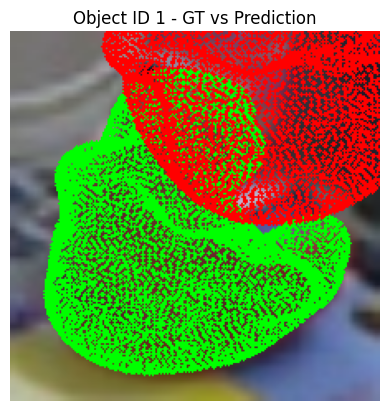

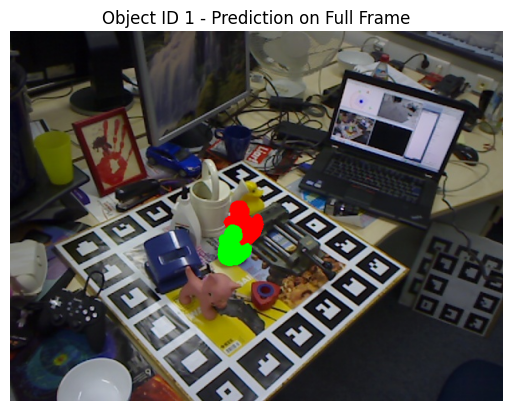

In [17]:
import cv2
import matplotlib.pyplot as plt

# Load model.
model = PoseNet()
model.load_state_dict(torch.load('/content/best_posenet.pt'))

# If we have a GPU, move the model to the device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

obj_id = 1
eval_dataset_id = "01" # 03 is missing.

eval_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/data", eval_dataset_id)
models_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/models")
dataset = PoseEstimationDataset(eval_root, models_root)

# Load one sample (may contain multiple objects)
img_idx = 1
data_item = dataset[img_idx]
original_image = np.array(data_item['original_rgb'])
original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)  # For OpenCV

# For each object in the image
HOW_MANY = 1
counter = 0
for obj in data_item['objects']:
    if counter >= HOW_MANY:
        break
    counter += 1
    cropped_rgb_tensor = obj['cropped_rgb'].unsqueeze(0).to(device)
    cropped_K = obj['cropped_K'].cpu().numpy()
    R_gt = obj['rotation']
    t_gt = obj['translation']
    obj_id = obj['object_id']

    # Forward pass
    t_pred, R_pred = model(cropped_rgb_tensor)
    #R_pred = quat_to_rotmat(quat_pred).detach().cpu().numpy().squeeze()

    # Turn into numpy.
    t_pred = t_pred.detach().cpu().numpy().squeeze()
    R_pred = R_pred.detach().cpu().numpy().squeeze()

    # Load correct model
    model_points = torch.from_numpy(dataset.load_3D_model(obj_id)).to(device)
    model_points_np = model_points.detach().cpu().numpy() # Turn into numpy.

    # Project model points
    def project(pts, R, t, K):
        proj = (K @ (pts @ R.T + t).T).T
        return proj[:, :2] / proj[:, 2:3]

    pts_gt = project(model_points_np, R_gt, t_gt, cropped_K).astype(int)
    pts_pred = project(model_points_np, R_pred, t_pred, cropped_K).astype(int)

# ------ PLOTTING IN CROPPED IMAGE ------

    # Visualize on cropped image.
    vis = obj['cropped_rgb'].cpu().numpy().transpose(1, 2, 0)
    vis = (vis * 0.229 + 0.485).clip(0, 1)  # Unnormalize
    vis = (vis * 255).astype(np.uint8)
    vis = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)

    for pt in pts_gt:
        cv2.circle(vis, tuple(pt), 1, (0, 255, 0), -1)  # Green = GT
    for pt in pts_pred:
        cv2.circle(vis, tuple(pt), 1, (0, 0, 255), -1)  # Red = Pred

    # Show per-object.
    add = computeADD(R_pred, t_pred, R_gt, t_gt, model_points)
    print(f"Object ID {obj_id} - ADD: {add:.6f}")
    plt.figure()
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f'Object ID {obj_id} - GT vs Prediction')
    plt.axis("off")
    plt.show()

# ------ PLOTTING IN ORIGINAL IMAGE ------

    original_K = data_item['original_K'].numpy()

    # Project using original intrinsics (uncropped.)
    pts_gt_orig = project(model_points_np, R_gt, t_gt, original_K).astype(int)
    pts_pred_orig = project(model_points_np, R_pred, t_pred, original_K).astype(int)

    # Clone the original image for drawing
    image_with_pred = original_image.copy()

    # Draw only predicted pose on full image
    for pt in pts_pred_orig:
        x, y = pt
        if 0 <= x < image_with_pred.shape[1] and 0 <= y < image_with_pred.shape[0]:
            cv2.circle(image_with_pred, (x, y), 1, (0, 0, 255), -1)  # Red = Predicted

    for pt in pts_gt_orig:
        x, y = pt
        if 0 <= x < image_with_pred.shape[1] and 0 <= y < image_with_pred.shape[0]:
            cv2.circle(image_with_pred, (x, y), 1, (0, 255, 0), -1)  # Green = GT

    # Show original image with prediction
    plt.figure()
    plt.imshow(cv2.cvtColor(image_with_pred, cv2.COLOR_BGR2RGB))
    plt.title(f'Object ID {obj_id} - Prediction on Full Frame')
    plt.axis("off")
    plt.show()


## Plotting 3D model in top of the cropped image

Projected object center: (133.6, 103.5)


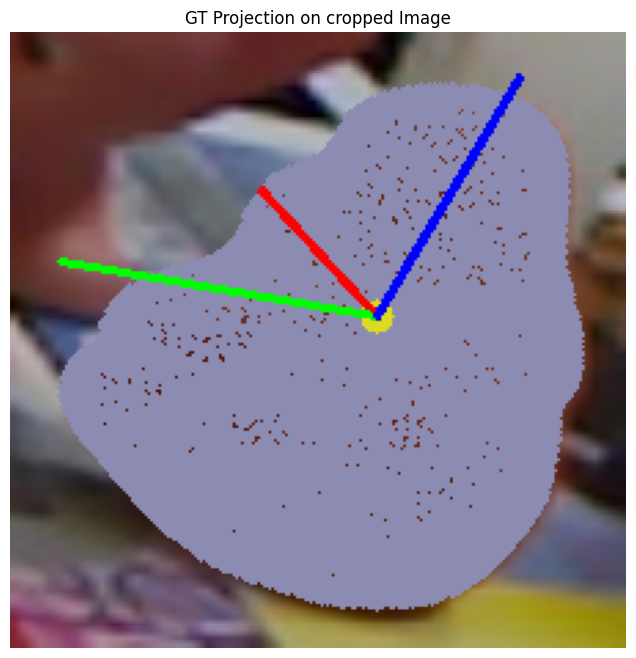

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

obj_id = 1
eval_dataset_id = "01" # 03 is missing.
PLOT_MODEL_ON_TOP = True
DRAW_MODEL_AXES = True
DRAW_OBJECT_CENTER = True

eval_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/data", eval_dataset_id)
models_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/models")
dataset = PoseEstimationDataset(eval_root, models_root)

# Load one test sample (image index within split)
img_idx = 0
sample_data = dataset[img_idx]
objects = sample_data['objects']               # list of dicts

# Get the object-specific data for the chosen obj_id
obj_sample = next(obj for obj in objects if obj['object_id'] == obj_id)

R_gt = obj_sample['rotation']
t_gt = obj_sample['translation']
cropped_K = obj_sample['cropped_K'].numpy()
cropped_rgb = obj_sample['cropped_rgb']

# Load 3D model
model_points = dataset.load_3D_model(obj_id)

# Project 3D model points to 2D
def project_3d_to_2d(points, K, R, t):
  transformed = points @ R.T + t
  projected = np.dot(K, transformed.T).T  # Use np.dot for matrix multiplication
  projected = projected.astype(np.float64) # Ensure correct data type
  return projected[:, :2] / projected[:, 2:3]

pts_2d = project_3d_to_2d(model_points, cropped_K, R_gt, t_gt)

def unnormalize_image(img_tensor, mean, std):
    img = img_tensor.clone().permute(1, 2, 0).cpu().numpy()  # [H, W, 3]
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

# Prepare image.
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# unnormalize
img_large = unnormalize_image(cropped_rgb, mean, std)
img_large = cv2.cvtColor(img_large, cv2.COLOR_RGB2BGR)

if PLOT_MODEL_ON_TOP:
  # --- Making 3D model ---
  # 1. Draw points with a more visible color and thickness
  point_color = (179, 140, 140)
  point_thickness = 2

  # 2. Draw projected points with boundary check and debug info
  for pt in pts_2d:
      x, y = int(pt[0]), int(pt[1])
      if 0 <= x < img_large.shape[1] and 0 <= y < img_large.shape[0]:
          cv2.circle(img_large, (x, y), point_thickness, point_color, -1)
      else:
          print(f"Point outside image bounds: ({x}, {y})")

if DRAW_OBJECT_CENTER:
    # Draw projected object center
    center_2d = np.dot(cropped_K, t_gt.reshape(3, 1)).flatten()
    center_2d = center_2d.astype(np.float64) # Ensure correct data type
    #center_2d = (cropped_K @ t_gt.reshape(3, 1)).flatten()
    cx = center_2d[0] / center_2d[2]
    cy = center_2d[1] / center_2d[2]
    cv2.circle(img_large, (int(cx), int(cy)), 6, (33, 218, 220), -1)


if DRAW_MODEL_AXES:
  #------Draw projected object center------


  # Define small axes in object space
  axis_length = 0.05  # meters
  axes_points = np.array([
      [0, 0, 0],  # origin
      [axis_length, 0, 0],  # X
      [0, axis_length, 0],  # Y
      [0, 0, axis_length],  # Z
  ])

  axes_2d = project_3d_to_2d(axes_points, cropped_K, R_gt, t_gt).astype(int)

  origin = tuple(axes_2d[0])
  cv2.line(img_large, origin, tuple(axes_2d[1]), (0, 0, 255), 2)   # X - Red
  cv2.line(img_large, origin, tuple(axes_2d[2]), (0, 255, 0), 2)   # Y - Green
  cv2.line(img_large, origin, tuple(axes_2d[3]), (255, 0, 0), 2)   # Z - Blue

# Show image
print(f"Projected object center: ({cx:.1f}, {cy:.1f})")
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_large, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("GT Projection on cropped Image")
plt.show()

## More experiements

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch

# Setup paths
obj_id = 1
img_idx = 0
eval_dataset_id = "01"  # Change if needed

eval_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/data", eval_dataset_id)
models_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/models")

dataset = PoseEstimationDataset(eval_root, models_root)

# Load one test sample
img_idx = 0
sample = dataset[img_idx]

# Ground truth pose
R_gt = sample["rotation"].cpu().numpy()  # [3, 3]
t_gt = sample["translation"].cpu().numpy()  # [3]
obj_id = int(sample["object_id"])
org_K = sample['original_K']
cropped_K = sample['cropped_K']

print("Original intrinsic matrix K:")
print(org_K)

print("Intrinsic matrix K:")
print(sample['original_K'])

print("Translation t_gt (meters):", sample["translation"].numpy())
print("Rotation R_gt:")
print(sample["rotation"].numpy())


# Convert tensor image to RGB numpy image
rgb_tensor = sample["cropped_rgb"]  # [3, H, W]
rgb_np = rgb_tensor.permute(1, 2, 0).cpu().numpy()  # [H, W, 3]
rgb_np = (rgb_np * 255).astype(np.uint8)  # Assume [0,1] range
rgb_np = cv2.cvtColor(rgb_np, cv2.COLOR_RGB2BGR)

# Load the original image from disk
img_path = os.path.join(dataset.rgb_dir, f"{img_idx:04d}.png")
rgb_image = np.array(Image.open(img_path).convert("RGB"))
rgb_np = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)

# 3D model points
model_points = dataset.load_3D_model(obj_id)  # [N, 3]

# Project 3D points into 2D
def project_3d_to_2d(points, K, R, t):
    transformed = points @ R.T + t
    projected = (K @ transformed.T).T
    return projected[:, :2] / projected[:, 2:3]



#R_test = R_gt.copy()
#R_test[1, :] *= -1

pts_2d = project_3d_to_2d(model_points, cropped_K, R_gt, t_gt)

# Draw on image
image_vis = rgb_np.copy()
for pt in pts_2d:
    x, y = int(pt[0]), int(pt[1])
    if 0 <= x < image_vis.shape[1] and 0 <= y < image_vis.shape[0]:
        cv2.circle(image_vis, (x, y), 2, (255, 0, 0), -1)  # Blue dots = GT

# Show
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB))
plt.title("Ground Truth Pose Projection")
plt.axis("off")
plt.show()


KeyError: 'rotation'

## Plotting 3D model in top of the original image

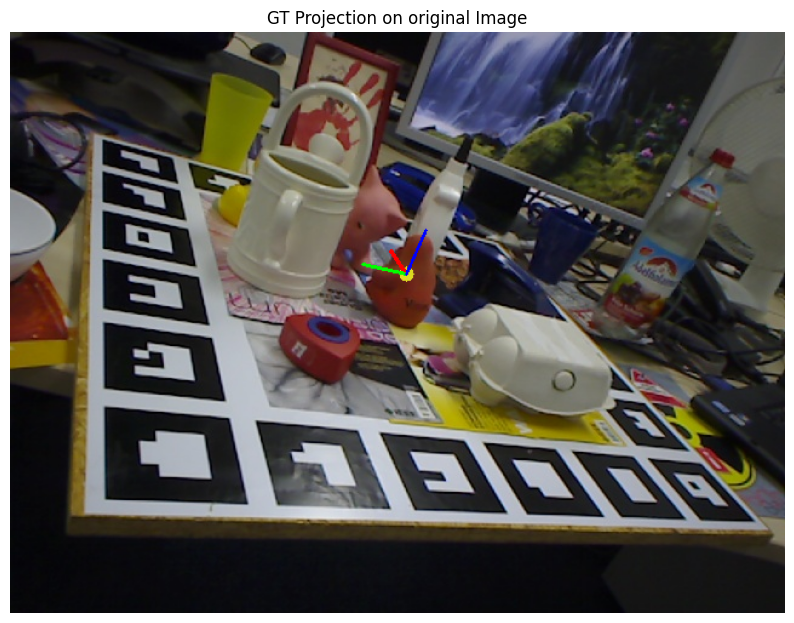

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

obj_id = 1
eval_dataset_id = "01"
DRAW_BB = False
DRAW_MODEL_AXES = True
DRAW_MODEL_ON_TOP = False
DRAW_OBJECT_CENTER = True

eval_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/data", eval_dataset_id)
models_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/models")
dataset = PoseEstimationDataset(eval_root, models_root)

# Load one test sample (image index within split)
img_idx = 0
sample_data = dataset[img_idx]

org_rgb = sample_data['original_rgb']          # tensor [3, H, W]
org_K = sample_data['original_K'].numpy()      # tensor → numpy
objects = sample_data['objects']               # list of dicts

# Get the object-specific data for the chosen obj_id
obj_sample = next(obj for obj in objects if obj['object_id'] == obj_id)

R_gt = obj_sample['rotation']
t_gt = obj_sample['translation']
bbox = obj_sample['bbox']

# Load 3D model
model_points = dataset.load_3D_model(obj_id)

# Project 3D model points to 2D
def project_3d_to_2d(points, K, R, t):
    transformed = points @ R.T + t
    projected = (K @ transformed.T).T
    return projected[:, :2] / projected[:, 2:3]

pts_2d = project_3d_to_2d(model_points, org_K, R_gt, t_gt)

# Prepare image
org_rgb_np = np.array(org_rgb)
image_vis = cv2.cvtColor(org_rgb_np, cv2.COLOR_RGB2BGR)

if DRAW_MODEL_ON_TOP:
    # --- Making 3D model ---
    # 1. Draw points with a more visible color and thickness
    point_color = (179, 140, 140)
    point_thickness = 2

    # 2. Draw projected points with boundary check and debug info
    for pt in pts_2d:
        x, y = int(pt[0]), int(pt[1])
        if 0 <= x < image_vis.shape[1] and 0 <= y < image_vis.shape[0]:
            cv2.circle(image_vis, (x, y), point_thickness, point_color, -1)
        else:
            print(f"Point outside image bounds: ({x}, {y})")

if DRAW_OBJECT_CENTER:
    # Draw projected object center
    center_2d = (org_K @ t_gt.reshape(3, 1)).flatten()
    cx = center_2d[0] / center_2d[2]
    cy = center_2d[1] / center_2d[2]
    cv2.circle(image_vis, (int(cx), int(cy)), 6, (33, 218, 220), -1)

if DRAW_BB:
    # Draw GT bounding box
    x, y, w, h = bbox
    cv2.rectangle(image_vis, (x, y), (x + w, y + h), (255, 255, 0), 2)

if DRAW_MODEL_AXES:
    #------Draw projected object center------

    # Define small axes in object space
    axis_length = 0.05  # meters
    axes_points = np.array([
        [0, 0, 0],  # origin
        [axis_length, 0, 0],  # X
        [0, axis_length, 0],  # Y
        [0, 0, axis_length],  # Z
    ])

    axes_2d = project_3d_to_2d(axes_points, org_K, R_gt, t_gt).astype(int)

    origin = tuple(axes_2d[0])
    cv2.line(image_vis, origin, tuple(axes_2d[1]), (0, 0, 255), 2)   # X - Red
    cv2.line(image_vis, origin, tuple(axes_2d[2]), (0, 255, 0), 2)   # Y - Green
    cv2.line(image_vis, origin, tuple(axes_2d[3]), (255, 0, 0), 2)   # Z - Blue


# Show image
#print(f"Projected object center: ({cx:.1f}, {cy:.1f})")
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("GT Projection on original Image")
plt.show()